In [11]:
# Standard libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Plot settings
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "text.usetex": False,  # Remove if slow or unsupported
    # "font.family": 'Times New Roman',
    "figure.dpi": 100,
    "font.size": 14
})

# CSV / Data utilities
from csv_utils import load_model_data
from plot_utils import plot_predictions

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [12]:
csv_file = 'data.csv'
full_data = load_model_data(csv_file,load_gauge_fidelity=True)

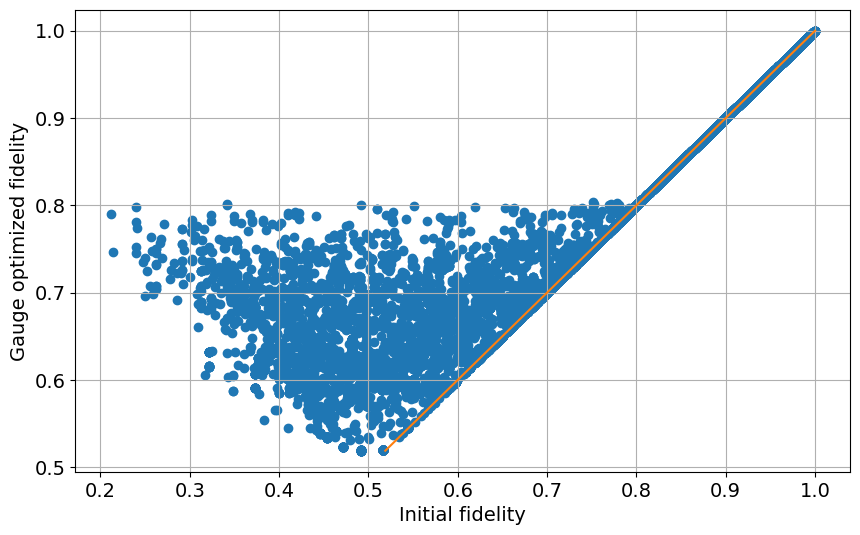

In [13]:
# -----------------------------
# 1. Prepare data
# -----------------------------
F_naive = np.array(full_data['model_average_fidelity'])
F = np.array(full_data['model_average_fidelity_gauge'])
P = np.array(full_data['P_vector'])

# mask = F > 0.65
# F_naive = F_naive[mask]
# F = F[mask]
# P = P[mask]

plt.scatter(F_naive,F)
plt.plot([min(F),max(F)],[min(F),max(F)],color = 'C1')
plt.xlabel('Initial fidelity')
plt.ylabel('Gauge optimized fidelity')
plt.grid()
# plt.axhline(y=0.7,color='k')

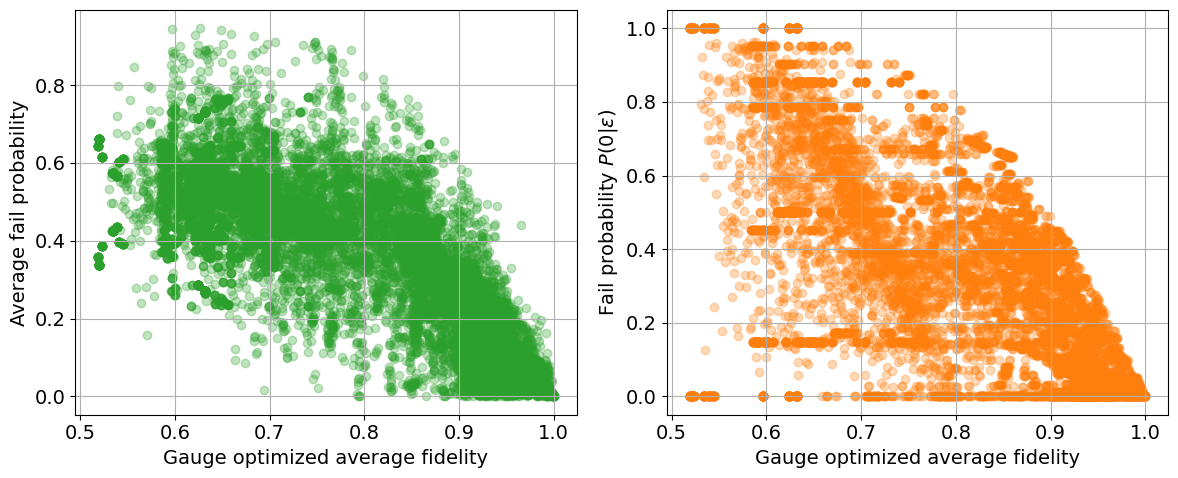

In [14]:
import matplotlib.pyplot as plt

# Example data (replace with your actual F and P)
# F = [...]
# P = [...]

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # width=12, height=5

# Plot 1: Average over all elements in each P vector
P_avg_all = [sum(pvector)/3 for pvector in P]
axes[0].scatter(F, P_avg_all, alpha=0.3, color='C2')
# axes[0].plot([min(F), max(F)], [min(F), max(F)], color='C1')  # optional line
axes[0].set_xlabel('Gauge optimized average fidelity')
axes[0].set_ylabel('Average fail probability')
axes[0].grid(True)

# Plot 2: Only first element of each P vector
P_avg_first = [pvector[0] for pvector in P]
axes[1].scatter(F, P_avg_first, alpha=0.3, color='C1')
# axes[1].plot([min(F), max(F)], [min(F), max(F)], color='C1')  # optional line
axes[1].set_xlabel('Gauge optimized average fidelity')
axes[1].set_ylabel(r'Fail probability $P(0|\epsilon)$')
axes[1].grid(True)

plt.tight_layout()  # adjusts spacing to prevent overlap
plt.show()


In [15]:

# -----------------------------
# 2. Train / Temp split
# -----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    P, F,
    test_size=0.2,      # 80% train, 20% temp
    random_state=42
)

# -----------------------------
# 3. Validation / Test split
# -----------------------------
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # 10% val, 10% test
    random_state=42
)


In [16]:
len(F)

12734

In [17]:

# -----------------------------
# 4. Model
# -----------------------------
model = Pipeline([
    # Step 1: create polynomial features (degree=2)
    ('poly', PolynomialFeatures(degree=5, include_bias=False,interaction_only=False)),
    
    # Step 2: optionally scale features
    ('scaler', StandardScaler()),
    
    # Step 3: gradient boosting regressor
    ('gbr', GradientBoostingRegressor(
        n_estimators=5000,
        max_depth=10,
        learning_rate=0.01,
        subsample=0.9,
        validation_fraction=0.1,
        n_iter_no_change=100,
        tol=1e-4,
        loss='huber',
    ))
])

# -----------------------------
# 5. Train on TRAIN ONLY
# -----------------------------
model.fit(X_train, y_train)


,steps,"[('poly', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,5
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


In [18]:
# -----------------------------
# 6. Validate
# -----------------------------
val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
print("Validation MSE:", val_mse)


Validation MSE: 0.002302310874858104


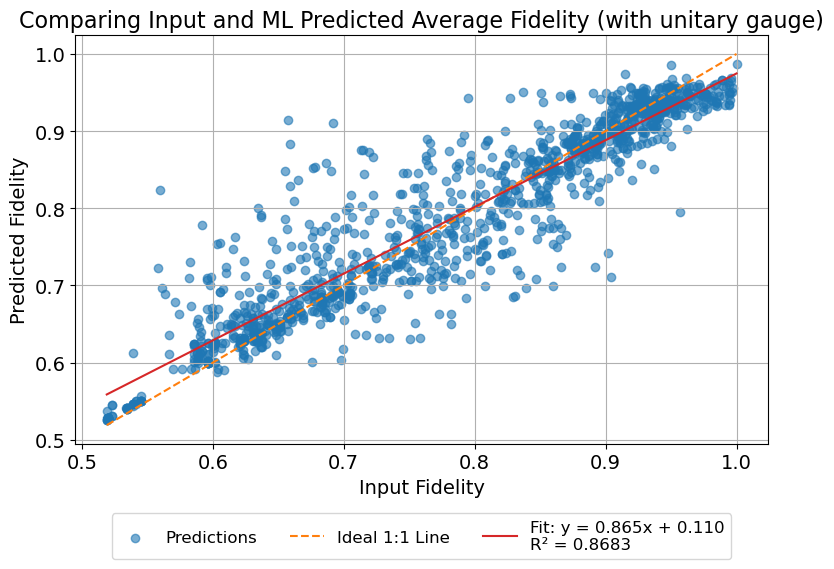

In [19]:
# Assuming you already have y_val and val_pred
plot_predictions(y_val, val_pred)


In [20]:
# # -----------------------------
# # 7. Final Test (only once!)
# # -----------------------------
# test_pred = model.predict(X_test)
# test_mse = mean_squared_error(y_test, test_pred)
# print("Test MSE:", test_mse)

# plot_predictions(y_test, test_pred)